Load the clean data

In [2]:
import pandas as pd
import pyodbc

conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=MBETHIE-PC\SQLEXPRESS;'
    r'Database=Retail Inventory Analytics;'
    r'Trusted_Connection=yes;'
)
df = pd.read_sql("SELECT * FROM supermarket_sales_clean", conn)
df['Date'] = pd.to_datetime(df['Date'])


C:\Users\Mbethie\AppData\Local\Temp\ipykernel_8908\3452372819.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM supermarket_sales_clean", conn)


check data

In [5]:
df.info()
#data shows that there are 1000 entries with 17 columns
df.describe()
df.isnull().sum()
#no missing values in the dataset
df.dtypes
# Date column is in object format, converting to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.duplicated(subset=['Invoice_ID']).sum()
#no duplicate invoice IDs found


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Invoice_ID               1000 non-null   object        
 1   Branch                   1000 non-null   object        
 2   City                     1000 non-null   object        
 3   Customer_type            1000 non-null   object        
 4   Gender                   1000 non-null   object        
 5   Product_line             1000 non-null   object        
 6   Unit_price               1000 non-null   float64       
 7   Quantity                 1000 non-null   float64       
 8   Tax_5                    1000 non-null   float64       
 9   Total                    1000 non-null   float64       
 10  Date                     1000 non-null   datetime64[ns]
 11  Time                     1000 non-null   object        
 12  Payment                  1000 non-n

np.int64(0)

In [6]:
#Business Question 1 — Which branches drive revenue?
branch_perf = (
    df.groupby('Branch')
      .agg(
          total_revenue=('Total', 'sum'),
          transactions=('Invoice_ID', 'count'),
          avg_rating=('Rating', 'mean')
      )
      .reset_index()
      .sort_values(by='total_revenue', ascending=False)
)

branch_perf


,Branch,total_revenue,transactions,avg_rating
2,C,110568.86,328,7.072866
0,A,106200.57,340,7.027059
1,B,106198.00,332,6.818072


In [8]:
#Business Question 2 — Product line performance
product_perf = (
    df.groupby('Product_line')
      .agg(
          units_sold=('Quantity', 'sum'),
          revenue=('Total', 'sum'),
          gross_income=('gross_income', 'sum'),
          avg_unit_price=('Unit_price', 'mean')
      )
      .reset_index()
      .sort_values(by='revenue', ascending=False)
)

product_perf


,Product_line,units_sold,revenue,gross_income,avg_unit_price
2,Food and beverages,952.0,56144.96,2673.68,56.008851
5,Sports and travel,920.0,55123.00,2625.07,56.993253
0,Electronic accessories,971.0,54337.64,2587.61,53.551588
1,Fashion accessories,902.0,54306.03,2586.13,57.153652
4,Home and lifestyle,911.0,53861.96,2564.90,55.316937
3,Health and beauty,854.0,49193.84,2342.66,54.854474


In [9]:
#Business Question 3 — Customer behavior segmentation
customer_seg = (
    df.groupby(['Customer_type', 'Gender'])
      .agg(
          transactions=('Invoice_ID', 'count'),
          total_revenue=('Total', 'sum'),
          avg_spend=('Total', 'mean')
      )
      .reset_index()
      .sort_values(by='total_revenue', ascending=False)
)

customer_seg


,Customer_type,Gender,transactions,total_revenue,avg_spend
0,Member,Female,261,88147.12,337.728429
2,Normal,Female,240,79736.14,332.233917
3,Normal,Male,259,79007.48,305.048185
1,Member,Male,240,76076.69,316.986208


In [10]:
#Business Question 4 — Time trends (sales over time)
daily_sales = (
    df.groupby('Date')
      .agg(
          daily_revenue=('Total', 'sum'),
          transactions=('Invoice_ID', 'count')
      )
      .reset_index()
)

daily_sales.head()


,Date,daily_revenue,transactions
0,2019-01-01,4745.19,12
1,2019-01-02,1945.50,8
2,2019-01-03,2078.12,8
3,2019-01-04,1623.68,6
4,2019-01-05,3536.69,12


In [11]:
# Weekly revenue
weekly_sales = (
    df.set_index('Date')
      .resample('W')
      .agg(
          weekly_revenue=('Total', 'sum'),
          transactions=('Invoice_ID', 'count')
      )
      .reset_index()
)

weekly_sales.head()


,Date,weekly_revenue,transactions
0,2019-01-06,17543.40,55
1,2019-01-13,24461.26,73
2,2019-01-20,28693.43,82
3,2019-01-27,29286.95,93
4,2019-02-03,28360.53,83


In [12]:
# Revenue per unit
df['RevenuePerUnit'] = df['Total'] / df['Quantity']

# Weekly revenue
weekly = df.groupby([pd.Grouper(key='Date', freq='W'), 'Branch'])['Total'].sum().reset_index()
weekly.head()

,Date,Branch,Total
0,2019-01-06,A,7433.52
1,2019-01-06,B,5735.18
2,2019-01-06,C,4374.70
3,2019-01-13,A,6926.36
4,2019-01-13,B,8115.24


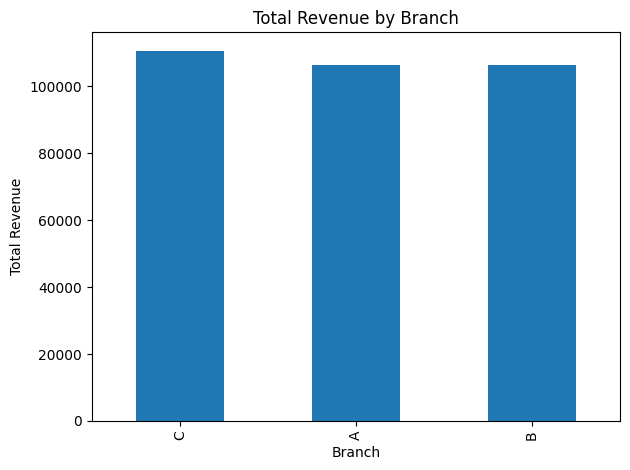

In [13]:
#Branch revenue comparison
import matplotlib.pyplot as plt

branch_rev = (
    df.groupby('Branch')['Total']
      .sum()
      .sort_values(ascending=False)
)

plt.figure()
branch_rev.plot(kind='bar')
plt.title('Total Revenue by Branch')
plt.xlabel('Branch')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()


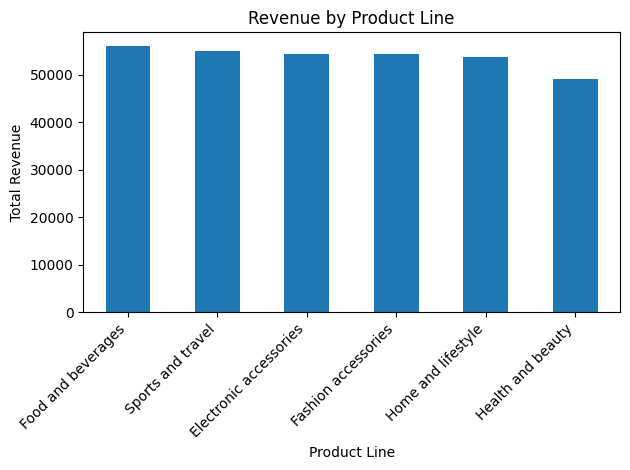

In [14]:
#Product line revenue performance
product_rev = (
    df.groupby('Product_line')['Total']
      .sum()
      .sort_values(ascending=False)
)

plt.figure()
product_rev.plot(kind='bar')
plt.title('Revenue by Product Line')
plt.xlabel('Product Line')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


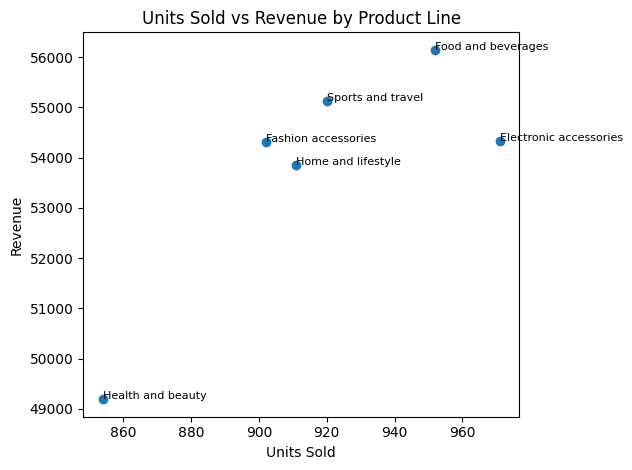

In [15]:
#Units sold vs revenue (volume vs value)
product_units = (
    df.groupby('Product_line')
      .agg(
          units_sold=('Quantity', 'sum'),
          revenue=('Total', 'sum')
      )
)

plt.figure()
plt.scatter(product_units['units_sold'], product_units['revenue'])
plt.xlabel('Units Sold')
plt.ylabel('Revenue')
plt.title('Units Sold vs Revenue by Product Line')

for label in product_units.index:
    x = product_units.loc[label, 'units_sold']
    y = product_units.loc[label, 'revenue']
    plt.text(x, y, label, fontsize=8)

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

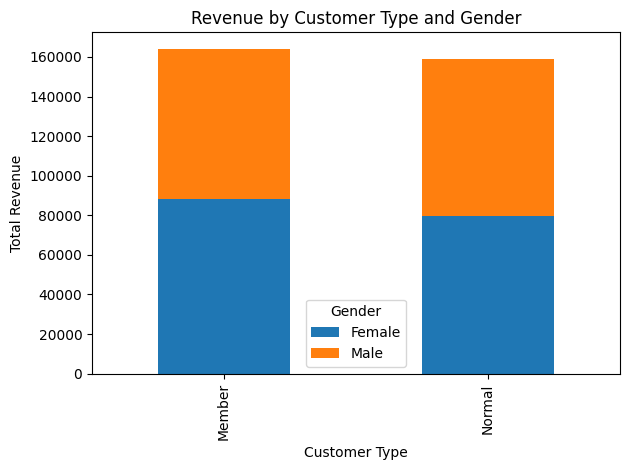

In [16]:
#Customer segmentation — revenue contribution
cust_rev = (
    df.groupby(['Customer_type', 'Gender'])['Total']
      .sum()
      .unstack()
)

plt.figure()
cust_rev.plot(kind='bar', stacked=True)
plt.title('Revenue by Customer Type and Gender')
plt.xlabel('Customer Type')
plt.ylabel('Total Revenue')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


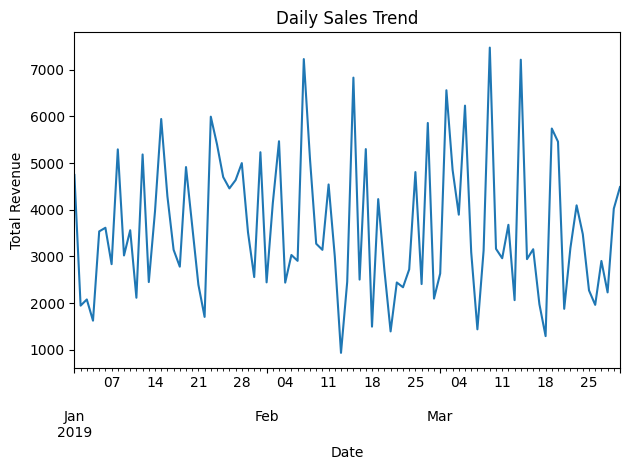

In [17]:
#Sales trend over time
daily_sales = df.groupby('Date')['Total'].sum()

plt.figure()
daily_sales.plot()
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()


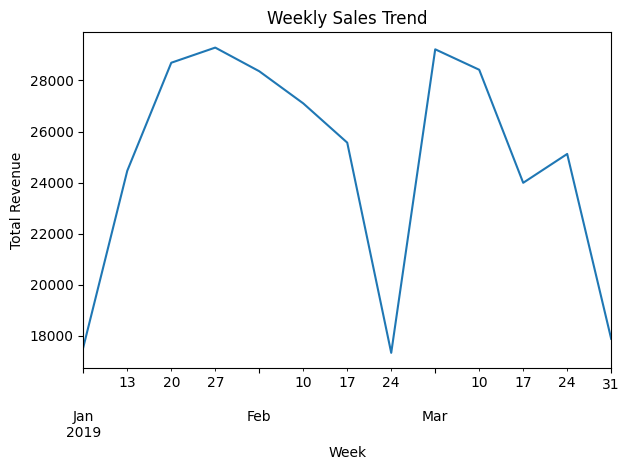

In [18]:
#Weekly trend 
weekly_sales = (
    df.set_index('Date')['Total']
      .resample('W')
      .sum()
)

plt.figure()
weekly_sales.plot()
plt.title('Weekly Sales Trend')
plt.xlabel('Week')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()


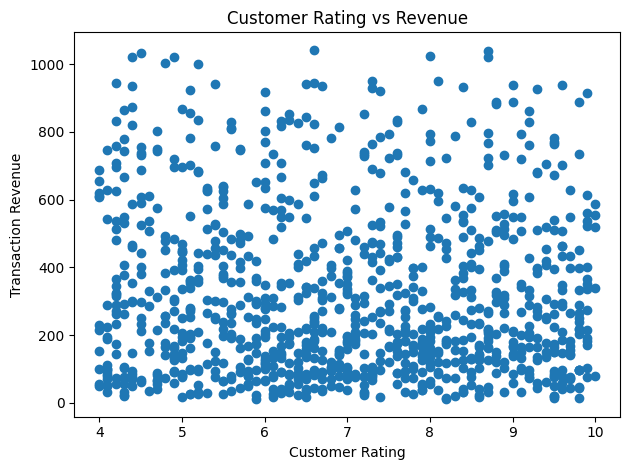

In [19]:
#Ratings vs revenue (customer satisfaction lens)
plt.figure()
plt.scatter(df['Rating'], df['Total'])
plt.xlabel('Customer Rating')
plt.ylabel('Transaction Revenue')
plt.title('Customer Rating vs Revenue')
plt.tight_layout()
plt.show()
